In [49]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import zipfile

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


zip_path = "/content/Data.zip"
extract_path = "/content/extracted_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load datasets
train_dir = "/content/extracted_data/Data/train"
val_dir = "/content/extracted_data/Data/val"
test_dir = "/content/extracted_data/Data/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

classes = train_dataset.classes
classes

for inputs, labels in train_loader:
    print(f'Inputs shape: {inputs.shape}')
    print(f'Labels shape: {labels.shape}')
    break
labels[:5]


Using device: cpu
Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


tensor([3, 0, 3, 3, 3])

In [50]:

import torch.nn.functional as F

class CNN_4Layer(nn.Module):
    def __init__(self):
        super(CNN_4Layer, self).__init__()
        # 8 filters, 11x11 kernel, stride 4, padding 0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0)
        # 3x3, stride 2
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        #  16 filters, 5x5 kernel, stride 1, padding 0
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        #  3x3, stride 2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x


In [51]:
class CNN_5Layer(nn.Module):
    def __init__(self):
        super(CNN_5Layer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # 32 filters, 3x3 kernel, stride 1, padding 0
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(288, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x


In [52]:
class CNN_6Layer(nn.Module):
    def __init__(self):
        super(CNN_6Layer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        #  32 filters, 3x3 kernel, stride 1, padding 0 (No Max Pooling)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)

        #  64 filters, 3x3 kernel, stride 1, padding 0
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x


In [53]:
import torch.optim as optim

model = CNN_4Layer().to(device)
learning_rate = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0
    total_val = 0
    correct_val = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    for val_inputs, val_labels in val_loader:
        model.eval()
        with torch.no_grad():
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    train_acc = correct_train / total_train
    val_accuracy = correct_val / total_val

    if(val_accuracy > best_val):
        best_val = val_accuracy
        torch.save(model.state_dict(), 'best_model_4layer.pth')
    print(f'Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Val Acc: {val_accuracy:.4f}' )


Epoch 1, Train Acc: 0.2560, Val Acc: 0.3000
Epoch 2, Train Acc: 0.4080, Val Acc: 0.3800
Epoch 3, Train Acc: 0.4920, Val Acc: 0.5000
Epoch 4, Train Acc: 0.6000, Val Acc: 0.6400
Epoch 5, Train Acc: 0.6600, Val Acc: 0.6000
Epoch 6, Train Acc: 0.6680, Val Acc: 0.6200
Epoch 7, Train Acc: 0.7880, Val Acc: 0.7200
Epoch 8, Train Acc: 0.8640, Val Acc: 0.5800
Epoch 9, Train Acc: 0.8720, Val Acc: 0.6600
Epoch 10, Train Acc: 0.8880, Val Acc: 0.7000


In [54]:
import torch.optim as optim

model = CNN_5Layer().to(device)
learning_rate = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0
    total_val = 0
    correct_val = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    for val_inputs, val_labels in val_loader:
        model.eval()
        with torch.no_grad():
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    train_acc = correct_train / total_train
    val_accuracy = correct_val / total_val

    if(val_accuracy > best_val):
        best_val = val_accuracy
        torch.save(model.state_dict(), 'best_model_5layer.pth')
    print(f'Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Val Acc: {val_accuracy:.4f}' )

Epoch 1, Train Acc: 0.2120, Val Acc: 0.3000
Epoch 2, Train Acc: 0.3360, Val Acc: 0.3000
Epoch 3, Train Acc: 0.3920, Val Acc: 0.3800
Epoch 4, Train Acc: 0.4600, Val Acc: 0.4200
Epoch 5, Train Acc: 0.5040, Val Acc: 0.4200
Epoch 6, Train Acc: 0.4960, Val Acc: 0.4800
Epoch 7, Train Acc: 0.5960, Val Acc: 0.5200
Epoch 8, Train Acc: 0.5920, Val Acc: 0.6000
Epoch 9, Train Acc: 0.6320, Val Acc: 0.5200
Epoch 10, Train Acc: 0.6960, Val Acc: 0.6200


In [55]:
import torch.optim as optim

model = CNN_6Layer().to(device)
learning_rate = 0.001
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0
    total_val = 0
    correct_val = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    for val_inputs, val_labels in val_loader:
        model.eval()
        with torch.no_grad():
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    train_acc = correct_train / total_train
    val_accuracy = correct_val / total_val

    if(val_accuracy > best_val):
        best_val = val_accuracy
        torch.save(model.state_dict(), 'best_model_6layer.pth')
    print(f'Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Val Acc: {val_accuracy:.4f}' )

Epoch 1, Train Acc: 0.2000, Val Acc: 0.2000
Epoch 2, Train Acc: 0.2800, Val Acc: 0.3200
Epoch 3, Train Acc: 0.3720, Val Acc: 0.3800
Epoch 4, Train Acc: 0.4240, Val Acc: 0.4600
Epoch 5, Train Acc: 0.4120, Val Acc: 0.4600
Epoch 6, Train Acc: 0.4360, Val Acc: 0.5800
Epoch 7, Train Acc: 0.5320, Val Acc: 0.5600
Epoch 8, Train Acc: 0.6120, Val Acc: 0.4800
Epoch 9, Train Acc: 0.5600, Val Acc: 0.6000
Epoch 10, Train Acc: 0.6080, Val Acc: 0.6400
Epoch 11, Train Acc: 0.7080, Val Acc: 0.6000
Epoch 12, Train Acc: 0.7360, Val Acc: 0.5600
Epoch 13, Train Acc: 0.7040, Val Acc: 0.5600
Epoch 14, Train Acc: 0.6840, Val Acc: 0.5800
Epoch 15, Train Acc: 0.7160, Val Acc: 0.5800
Epoch 16, Train Acc: 0.6880, Val Acc: 0.5800
Epoch 17, Train Acc: 0.7120, Val Acc: 0.5600
Epoch 18, Train Acc: 0.7440, Val Acc: 0.6600
Epoch 19, Train Acc: 0.7680, Val Acc: 0.5600
Epoch 20, Train Acc: 0.7800, Val Acc: 0.6600
Epoch 21, Train Acc: 0.7560, Val Acc: 0.6400
Epoch 22, Train Acc: 0.7880, Val Acc: 0.6800
Epoch 23, Train Acc

In [56]:
model_4l = CNN_4Layer()
model_4l.load_state_dict(torch.load('best_model_4layer.pth'))
model_4l.to(device)
model_4l.eval()

model_5l = CNN_5Layer()
model_5l.load_state_dict(torch.load('best_model_5layer.pth'))
model_5l.to(device)
model_5l.eval()

model_6l = CNN_6Layer()
model_6l.load_state_dict(torch.load('best_model_6layer.pth'))
model_6l.to(device)
model_6l.eval()


<ipython-input-56-5a0078eee33e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_4l.load_state_dict(torch.load('best_model_4layer.pth'))
<ipython-input-56-5a0078eee33e

CNN_6Layer(
  (conv1): Conv2d(3, 8, kernel_size=(11, 11), stride=(4, 4))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

def plot_confusion_matrix(model, dataloader, classes):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Test accuracy of the model with 4 layers: 0.7500


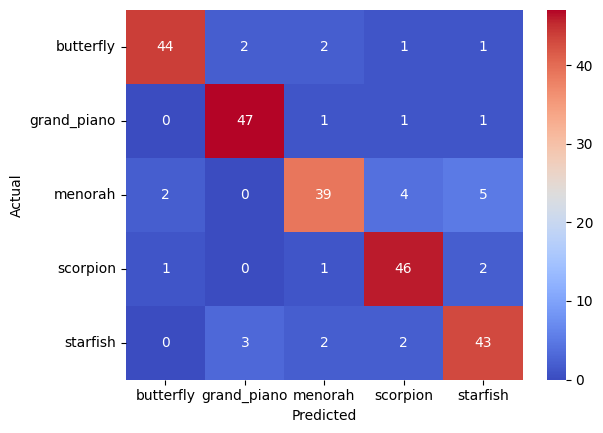

In [58]:
print(f'Test accuracy of the model with 4 layers: {calculate_accuracy(model_4l, test_loader):.4f}')
plot_confusion_matrix(model, train_loader, classes)

Test accuracy of the model with 5 layers: 0.5300


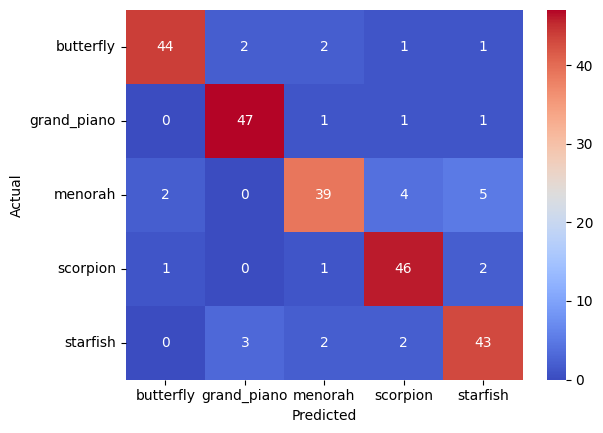

In [59]:
print(f'Test accuracy of the model with 5 layers: {calculate_accuracy(model_5l, test_loader):.4f}')
plot_confusion_matrix(model, train_loader, classes)

Test accuracy of the model with 6 layers: 0.6200


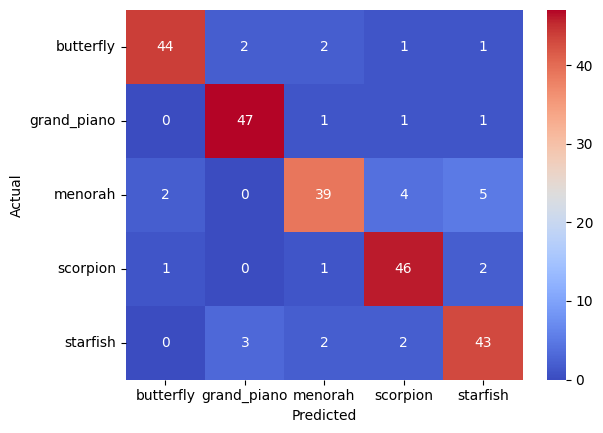

In [60]:
print(f'Test accuracy of the model with 6 layers: {calculate_accuracy(model_6l, test_loader):.4f}')
plot_confusion_matrix(model, train_loader, classes)

In [61]:
best_model = model_4l

In [62]:
for images, labels in train_loader:
    image = images[21]
    break
image.shape

torch.Size([3, 224, 224])

In [63]:
def plot_feature_maps(model, image):# Add batch dimension
    if len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension if missing
    image = image.to(device)
    conv1_out = model.conv1(image)
    print(conv1_out.shape)
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(8):
        axs[i//4, i%4].imshow(conv1_out[0, i].detach().cpu().numpy(), cmap='gray') # Added cmap='gray' for grayscale
        axs[i//4, i%4].axis('off')
    plt.show()

torch.Size([1, 8, 54, 54])


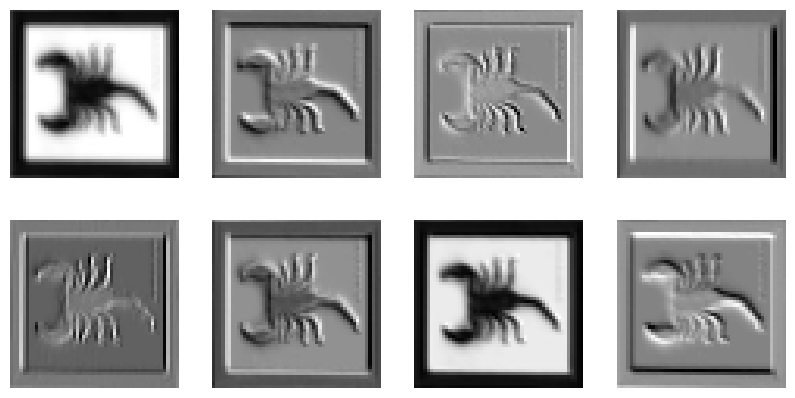

In [64]:
plot_feature_maps(best_model, image)

In [65]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def get_max_activated_patch(feature_map, image, kernel_size=3, stride=1):
    max_val, max_idx = torch.max(feature_map.view(feature_map.size(0), -1), dim=1)

    # Calculate channel, row, and column from the flattened index
    num_channels = feature_map.size(1)
    height, width = feature_map.size(2), feature_map.size(3)
    max_channel = max_idx // (height * width)
    max_row = (max_idx % (height * width)) // width
    max_col = max_idx % width

    # Convert to integers
    max_channel = max_channel.item()
    max_row = max_row.item()
    max_col = max_col.item()

    start_row = max_row * stride
    start_col = max_col * stride
    end_row = start_row + kernel_size
    end_col = start_col + kernel_size

    patch = image[:, :, start_row:end_row, start_col:end_col]
    return patch

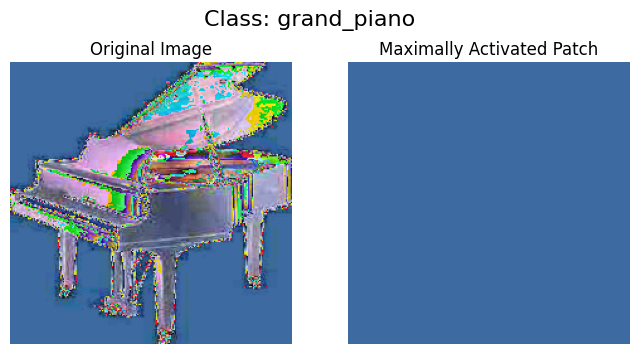

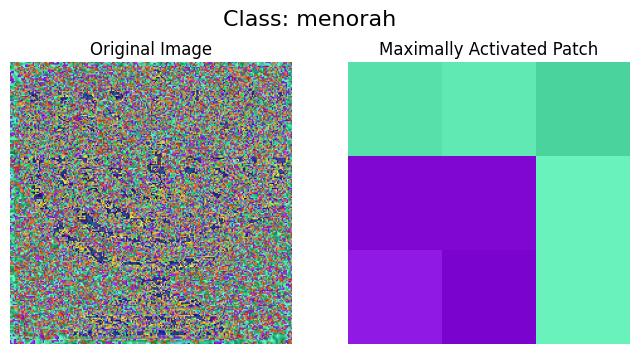

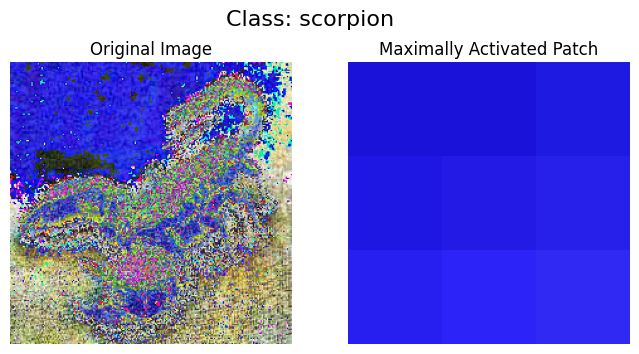

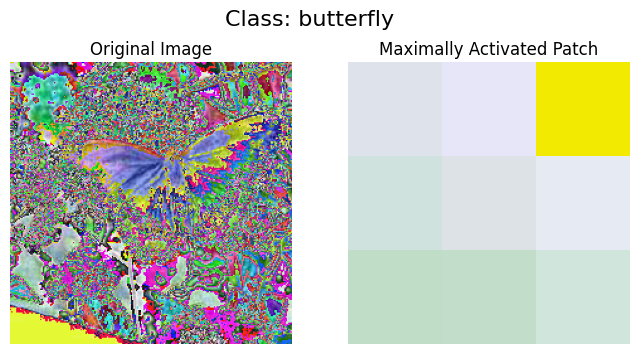

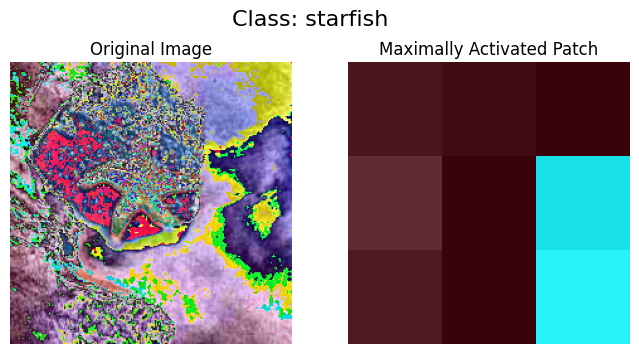

In [66]:
classes = train_dataset.classes
images_per_class = {}

for imgs, labels in train_loader:
    for img, label in zip(imgs, labels):
        label_name = classes[label.item()]
        if label_name not in images_per_class:
            images_per_class[label_name] = img.unsqueeze(0).to(device)  # Add batch dimension
        if len(images_per_class) == len(classes):
            break
    if len(images_per_class) == len(classes):
        break

best_model.eval()
for class_name, img in images_per_class.items():
    with torch.no_grad():
        x = F.relu(best_model.conv1(img))
        x = best_model.pool1(x)

        x = F.relu(best_model.conv2(x))
        x = best_model.pool2(x)
        last_conv_feature_map = x

    # maximally activates a neuron in the last conv layer
    max_patch = get_max_activated_patch(last_conv_feature_map, img)

    # patch to a PIL image
    max_patch_img = to_pil_image(max_patch.squeeze(0).cpu())

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f'Class: {class_name}', fontsize=16)

    axes[0].imshow(to_pil_image(img.squeeze(0).cpu()))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(max_patch_img)
    axes[1].set_title('Maximally Activated Patch')
    axes[1].axis('off')

    plt.show()